In [ ]:
!pip install classiq

In [ ]:
import classiq

classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:82: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [ ]:
from math import pi
from classiq.builtin_functions.exponentiation import PauliOperator
from classiq.builtin_functions import Exponentiation, PhaseEstimation, XGate, UnitaryGate, PhaseGate
from classiq import Model, synthesize, show, execute

# SET THE MATRIX

In [ ]:
# SET THE MATRIX
import numpy as np

#M = np.array([[0.25, 0], [0, 0.5]])

#M = np.array([[0.3, 0], [0, 0.35]])

# M = np.array([[0,0,0,0], [0, 3,0,0],[0, 0,0.5,0],[0, 0,0,0.75]])

# M = np.array([[0,0,0,0], [0, 3,0,0],[0, 0,-0.5,0],[0, 0,0,-0.75]])

#M = np.array([[0, 3, 4, 0], [-0.8, 3, 0, 0], [1, 0, -0.5, 5], [0, 0, 0, -0.75]])

M = np.array(
    [
        [0.38891555, 0.23315811, 0.21499372, 0.06119557],
        [0.23315811, 0.44435328, 0.25197881, -0.13087919],
        [0.21499372, 0.25197881, 0.44116509, -0.01961855],
        [0.06119557, -0.13087919, -0.01961855, 0.32556608],
    ]
)

M_t = M.transpose()

M = (M + M_t) / 2

#M = np.array([[0.7, 0, 0, 0], [0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]])

#M = np.array([[0.7, 0], [0, 0]])

print(M)

[[ 0.38891555  0.23315811  0.21499372  0.06119557]
 [ 0.23315811  0.44435328  0.25197881 -0.13087919]
 [ 0.21499372  0.25197881  0.44116509 -0.01961855]
 [ 0.06119557 -0.13087919 -0.01961855  0.32556608]]


In [ ]:
# SET THE VECTOR

eigen_vec = False

if eigen_vec:
    w, v = np.linalg.eig(M) #numpy.linalg.eig()
    print("the eigenvalues are", w)
    print("the eigenvectors are", v, sep="\n")
    ev = 1
    int_vec = v[:, ev]
else:
    int_vec = np.random.rand(np.shape(M)[0])

print("Your initial state is", int_vec)

Your initial state is [0.14989969 0.34421994 0.89624524 0.97508528]


In [ ]:
# SET MATRIX FOR QPE

In [ ]:
###this is the code to take a matrix and tranform it into pauli string

import itertools  # noqa
from itertools import product

from numpy import kron

Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


# generate all combinations of Pauli strings of size n
def generateAllPauliStrings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


# convert a Paulistring of size n to 2**n X 2**n matrix
def PauliString2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def HilbertSchmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()


# Naive decomposition, running over all HS products for all Pauli strings
def LCU_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generateAllPauliStrings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * HilbertSchmidt(PauliString2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist

In [ ]:
# DECOMPOSITION OF M IN PAULI OPERATORS
pauli_ops = LCU_naive(M)
print(pauli_ops)

[('II', (0.39999999999999997+0j)), ('IZ', (0.015040319999999996+0j)), ('IX', (0.10676978000000001+0j)), ('ZI', (0.016634415000000013+0j)), ('ZZ', (-0.042759185000000005+0j)), ('ZX', (0.12638833+0j)), ('XI', (0.042057264999999996+0j)), ('XZ', (0.172936455+0j)), ('XX', (0.15658719+0j)), ('YY', (0.09539162+0j))]


In [ ]:
pauli_operator = PauliOperator(pauli_list=pauli_ops)
N = pauli_operator.num_qubits
print(pauli_operator.pauli_list)

[('II', (0.39999999999999997+0j)), ('IZ', (0.015040319999999996+0j)), ('IX', (0.10676978000000001+0j)), ('ZI', (0.016634415000000013+0j)), ('ZZ', (-0.042759185000000005+0j)), ('ZX', (0.12638833+0j)), ('XI', (0.042057264999999996+0j)), ('XZ', (0.172936455+0j)), ('XX', (0.15658719+0j)), ('YY', (0.09539162+0j))]


In [ ]:
# SET THE NUMBER OF QUBIT; RESOLUTION

n_qpe = 7

# recommanded n_qpe:
get_recommended_n = False

import math

desired_resolution = 0.02


def get_nqpe(pauli_operator, desired_resolution):
    N = pauli_operator.num_qubits
    A = 0
    for a, b in pauli_operator.pauli_list:
        A = A + abs(b)
    nqpe = math.log2(2 * N * A / desired_resolution)
    return math.ceil(nqpe)


if get_recommended_n:
    n_qpe = get_nqpe(pauli_operator, desired_resolution)

print("number of qubits for QPE is", n_qpe)

number of qubits for QPE is 7


In [ ]:
# normalizing the operator
## we need to create a matrix such that its normalized version will have eigenvalues of [0,1/2^k] when k is the resolution of the QPE
normalize = True


def normalization_params(pauli_operator, N):
    A = 0
    for a, b in pauli_operator.pauli_list:
        A = A + abs(b)
    return N * A


def normalize_hamiltonian(pauli_operator, normalization_coeff, k):
    new_pauli_operator = []
    for a, b in pauli_operator.pauli_list:
        if a == "I" * N:
            new_pauli_operator.append(
                (
                    a,
                    (b + normalization_coeff)
                    * (1 - 1 / (2**k))
                    / (2 * normalization_coeff),
                )
            )
        else:
            new_pauli_operator.append(
                (a, b * (1 - 1 / (2**k)) / (2 * normalization_coeff))
            )
    return new_pauli_operator


if normalize:
    normalization_coeff = normalization_params(pauli_operator, N)
    new_pauli_operator = normalize_hamiltonian(
        pauli_operator, normalization_coeff, n_qpe
    )
    pauli_ops = new_pauli_operator
    print(pauli_ops)

    size = math.sqrt(M.size)
    I = np.eye(int(size))

    Mnew = (
        (M + normalization_coeff * I)
        * (1 - 1 / (2**n_qpe))
        / (2 * normalization_coeff)
    )

else:
    Mnew = M

[('II', (0.5805665439007456+0j)), ('IZ', (0.0031762446289031565+0j)), ('IX', (0.02254785405191989+0j)), ('ZI', (0.0035128887748861835+0j)), ('ZZ', (-0.009029969554672139+0j)), ('ZX', (0.026690938378873572+0j)), ('XI', (0.00888173669593511+0j)), ('XZ', (0.036521063802851444+0j)), ('XX', (0.03306839357091725+0j)), ('YY', (0.02014499164029562+0j))]


# SET THE QPE CIRCUIT

In [ ]:
# CONDITIONS AND PREFERENCES TO THE CIRCUIT
from classiq.model import Constraints, Preferences

constraints = Constraints()
preferences = Preferences()

model = Model(preferences=preferences, constraints=constraints)

In [ ]:
# SET INITIAL STATE
from classiq.builtin_functions import StatePreparation
my_amp = tuple(
    int_vec / np.linalg.norm(int_vec)
)  # amplitude is given by the eignevector

sp_upper = 0.00  # precision of the State Preparation

sp_params = StatePreparation(
    amplitudes=my_amp, error_metric={"L2": {"upper_bound": sp_upper}}
)

sp_out = model.StatePreparation(params=sp_params)

CALLING PHASE ESTIMATION

In [ ]:
from classiq.builtin_functions.qpe import (
    ExponentiationScaling,
    ExponentiationSpecification,
)

is_exact = False
exp_max_depth = 8000

if is_exact:
    my_unitary = scipy.linalg.expm(1j * 2 * np.pi * Mnew)
    exp_params = UnitaryGate(data=my_unitary.tolist())
    Qreg_name = {"IN": "TARGET", "OUT": "TARGET"}
else:
    po = pauli_ops
    exp_params = Exponentiation(
        pauli_operator=PauliOperator(pauli_list=po),
        evolution_coefficient=-2 * np.pi,
        #                          optimization=ExponentiationOptimization.MINIMIZE_ERROR,
        #                          constraints=ExponentiationConstraints(max_depth=exp_max_depth)
    )
    Qreg_name = {"IN": "IN", "OUT": "OUT"}

if is_exact:
    qpe_params = PhaseEstimation(size=n_qpe, unitary_params=exp_params)
else:
    qpe_params = PhaseEstimation(
        size=n_qpe,
        unitary_params=exp_params,
        exponentiation_specification=ExponentiationSpecification(
            scaling=ExponentiationScaling(max_depth=200, max_depth_scaling_factor=1.8)
        ),
    )

qpe_out = model.PhaseEstimation(
    params=qpe_params, in_wires={Qreg_name["IN"]: sp_out["OUT"]}
)

In [ ]:
# DEFINING THE REGISTER

model.set_outputs({"phase_result": qpe_out["PHASE_ESTIMATION"]})

# SINTHESIZING THE CIRCUIT

In [ ]:
from classiq.execution import ExecutionPreferences

num_shots = 10000
model.execution_preferences = ExecutionPreferences(num_shots=num_shots)

model.sample()
qmod = model.get_model()

In [ ]:
with open("qpe_for_matrix.qmod", "w") as f:
    f.write(qmod)

In [ ]:
from classiq import synthesize

qprog = synthesize(qmod)

In [ ]:
# SYNTHEZED CIRUIT SHOWN IN CLASSIQ PLATFORM
from classiq import GeneratedCircuit

circuit = GeneratedCircuit.from_qprog(qprog)
circuit.show()

Opening: https://platform.classiq.io/circuit/f9ec7e73-7c52-4694-b302-f40fb68ec2c7?version=0.30.0


# CIRCUIT AND CIRCUITALISIS

In [ ]:
# EXECUTION

from classiq import execute

results = execute(qprog).result()

In [ ]:
# IT SEEMS TO DEPEND ON THE SINTHESISED CIRCUIT

from classiq.execution import ExecutionDetails

results = results[0].value

In [ ]:
# MOST PROBABLE SOLUTION

number_of_solutions = 2  # number of phases sought

In [ ]:
solution = [
    sampled_state.state["phase_result"]
    for sampled_state in results.parsed_counts[:number_of_solutions]
]
print("Your qubit solution is", solution, sep="\n")

Your qubit solution is
[74.0, 88.0]


In [ ]:
# TRANSLATING INTO EIGENVALUES

dec_sol_vec = [sol / (2**n_qpe) for sol in solution]

print("Your decimal solutions are", dec_sol_vec, sep="\n")

Your decimal solutions are
[0.578125, 0.6875]


In [ ]:
# renormalize into the "real" solution -
if normalize:
    solution = [
        (
            (value * 2 * normalization_coeff / (1 - (1 / 2**n_qpe)))
            - normalization_coeff
        )
        for value in dec_sol_vec
    ]
else:
    solution = dec_sol_vec

In [ ]:
print(solution)

[0.38843867338582694, 0.9063569045669291]


In [ ]:
if normalize:
    energy_resolution = (
        (1 / (2**n_qpe)) * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
    )
else:
    energy_resolution = 1 / (2**n_qpe)

print("the resolution of results is", energy_resolution)

for sol in solution:
    print(
        "the solutions are between",
        sol - energy_resolution,
        "and",
        sol + energy_resolution,
    )

    ###if zero or exceed the normalization range need to add conditions

the resolution of results is 0.03699415937007874
the solutions are between 0.3514445140157482 and 0.42543283275590565
the solutions are between 0.8693627451968503 and 0.9433510639370078


In [ ]:
w, v = np.linalg.eig(M)

print("the eigenvalues are", w)
print("the eigenvectors are", v, sep="\n")

the eigenvalues are [0.9 0.4 0.1 0.2]
the eigenvectors are
[[ 0.51510515  0.41480695  0.5588446  -0.50029451]
 [ 0.61747259 -0.30596016 -0.64233734 -0.3354381 ]
 [ 0.58498122  0.11134965  0.09256217  0.79801659]
 [-0.10578874  0.8496616  -0.51626321  0.01887348]]


# SOLUTION HISTOGRAM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

energy_vec = []
energy_prob = []

for sampled_state in results.parsed_counts:
    temp = sampled_state.state["phase_result"] / (2**n_qpe)
    if normalize:
        temp2 = (
            temp * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
        ) - normalization_coeff
    else:
        temp2 = temp
    energy_vec.append(temp2)
    energy_prob.append(sampled_state.shots / num_shots)

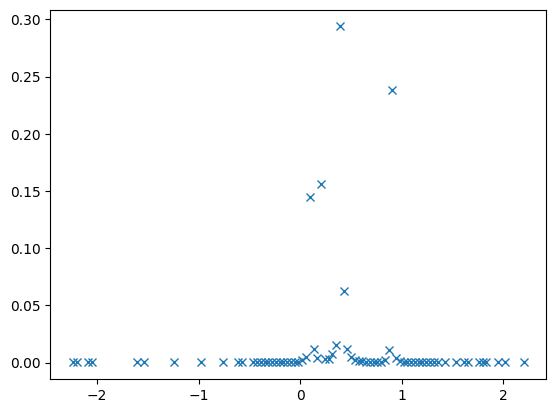

In [ ]:
plt.plot(energy_vec, energy_prob, "x")
plt.show()

# FIT CURVE FUNCTION

[0.99004468]


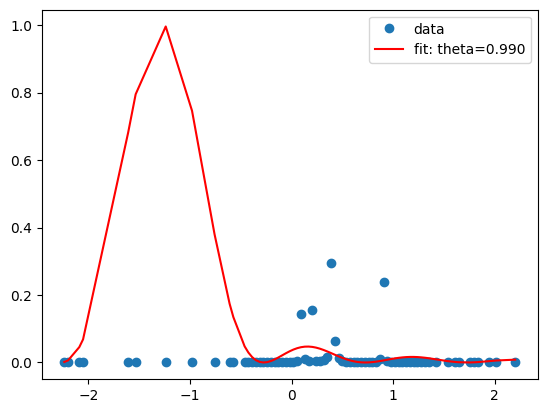

In [ ]:
# FUNCTION FOR SINGLE PHASE CASE

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def QPEProbability(y,theta):
    M = 2**7
    return ((1/M**2)*( (1-np.cos( ((2*np.pi)/M) * (y-(theta*M)) * M )) / (1-np.cos( ((2*np.pi)/M) * (y-(theta*M)) ))  ))
    #return ((1/M**2)*( (1-np.cos( (2*np.pi) * (y/M-theta) * M )) / (1-np.cos( (2*np.pi) * (y/M-theta) ))  ))
    #return (1/M**2)*( (1-np.cos((y/M-theta) * M)) / (1-np.cos(y/M-theta)) )

# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)

#SUBLIST DATA
#xdata = np.array(energy_vec[:21])
#ydata = np.array(energy_prob[:21])

#energy_vec.pop(1)
#energy_prob.pop(1)
#xdata = np.array(energy_vec)
#ydata = np.array(energy_prob)

# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)
plt.plot(xdata, ydata, 'o', label='data')

#x_n = np.linspace(np.min(xdata), np.max(xdata), 300)
x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, parameters), 'r-', label='fit: theta=%5.3f' % parameters)
plt.legend()

[0.98229462 0.99907091]


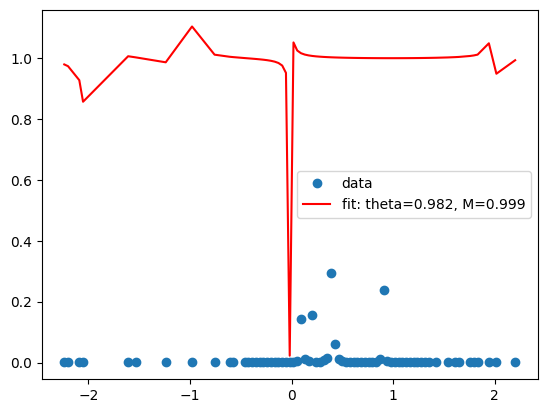

In [ ]:
# FUNCTION FOR SINGLE PHASE CASE WITH M AS A FITTING PARAMETER

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def QPEProbability(y,theta,M):
    #M = 2**7
    #return ((1/M**2)*( (1-np.cos( ((2*np.pi)/M) * (y-(theta*M)) * M )) / (1-np.cos( ((2*np.pi)/M) * (y-(theta*M)) ))  ))
    return ((1/M**2)*( (1-np.cos( (2*np.pi) * (y/M-theta) * M )) / (1-np.cos( (2*np.pi) * (y/M-theta) ))  ))

# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)

# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)

plt.plot(xdata, ydata, 'o', label='data')


x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, *parameters), 'r-', label='fit: theta=%5.3f, M=%5.3f' % tuple(parameters))
plt.legend()

CURVE_FIT IMPLEMENTING THE FUNCTION FOR MULTIPLE PHASES

In [ ]:
# WITH ONE PHASE
from math import cos, sin, pi
import numpy as np

def QPEProbability(y,t1,a1):

    M = 2**7

    theta = [t1]
    amplitude = [a1] #if amplitude are numbers, the result equals the above single phase function

    py = []
    for i in range(len(y)):
        py_result = 0
        term1 = 0
        term2 = 0
        for j in range(len(amplitude)):
            if y[i]-theta[j]*M == 0:
                term1 = term1 + (amplitude[j].conjugate() * amplitude[j]/(M*M))
            else:
                term2 = term2 + ((amplitude[j].conjugate() * amplitude[j])/(M*M))*((1-cos((2*pi*(y[i]-theta[j]*M)*M)/M))/(1-cos((2*pi*(y[i]-theta[j]*M))/M)))
            py_result = py_result + term1 + term2
        py.append(py_result)


    return py

[1.00303921 0.20699493]


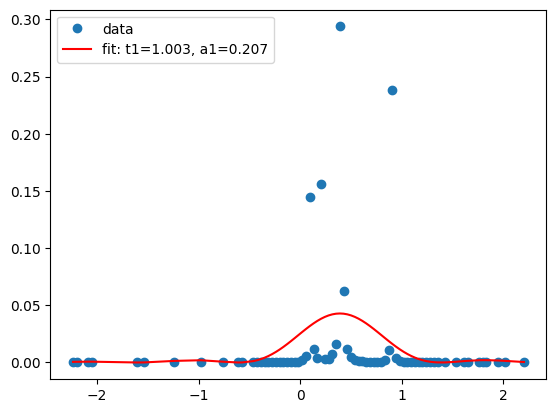

In [ ]:
# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)


# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)

plt.plot(xdata, ydata, 'o', label='data')


x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, *parameters), 'r-', label='fit: t1=%5.3f, a1=%5.3f' % tuple(parameters))
plt.legend()

In [ ]:
# WITH ONE PHASE AND FREE M
from math import cos, sin, pi
import numpy as np

def QPEProbability(y,t1,a1,M):

    #M = 2**7

    theta = [t1]
    amplitude = [a1] #if amplitude are numbers, the result equals the above single phase function

    py = []
    for i in range(len(y)):
        py_result = 0
        term1 = 0
        term2 = 0
        for j in range(len(amplitude)):
            if y[i]-theta[j]*M == 0:
                term1 = term1 + (amplitude[j].conjugate() * amplitude[j]/(M*M))
            else:
                term2 = term2 + ((amplitude[j].conjugate() * amplitude[j])/(M*M))*((1-cos((2*pi*(y[i]-theta[j]*M)*M)/M))/(1-cos((2*pi*(y[i]-theta[j]*M))/M)))
            py_result = py_result + term1 + term2
        py.append(py_result)


    return py

[0.76185216 0.12022369 0.99966725]


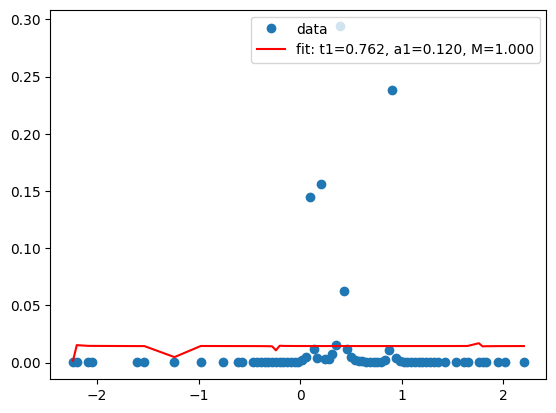

In [ ]:
# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)


# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)

plt.plot(xdata, ydata, 'o', label='data')


x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, *parameters), 'r-', label='fit: t1=%5.3f, a1=%5.3f, M=%5.3f' % tuple(parameters))
plt.legend()

In [ ]:
# WITH TWO PHASES
from math import cos, sin, pi, sqrt
import numpy as np

def QPEProbability(y,t1,t2,a1,a2):

    M = 2**7

    theta = [t1,t2]
    amplitude = [a1,a2] # [1/sqrt(2),1/sqrt(2)] [sqrt(2/3),1/sqrt(3)]

    py = []
    for i in range(len(y)):
        py_result = 0
        term1 = 0
        term2 = 0
        for j in range(len(amplitude)):
            if y[i]-theta[j]*M == 0:
                term1 = term1 + (amplitude[j].conjugate() * amplitude[j]/(M*M))
            else:
                term2 = term2 + ((amplitude[j].conjugate() * amplitude[j])/(M*M))*((1-cos((2*pi*(y[i]-theta[j]*M)*M)/M))/(1-cos((2*pi*(y[i]-theta[j]*M))/M)))
            py_result = py_result + term1 + term2
        py.append(py_result)


    return py

[ 1.00302970e+00  9.94139968e-01  1.46394270e-01 -1.59766814e-04]


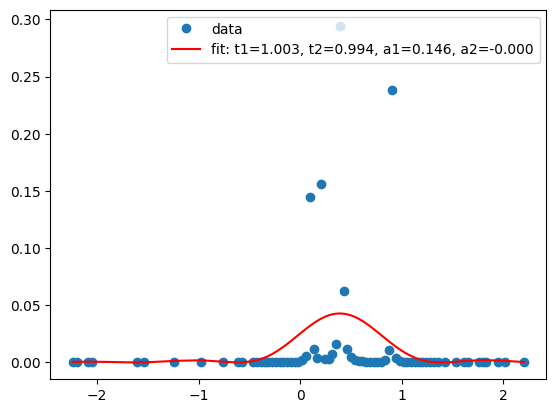

In [ ]:
# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)


# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)

plt.plot(xdata, ydata, 'o', label='data')


x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, *parameters), 'r-', label='fit: t1=%5.3f, t2=%5.3f, a1=%5.3f, a2=%5.3f' % tuple(parameters))
plt.legend()

In [ ]:
# WITH FIVE PHASES
from math import cos, sin, pi
import numpy as np

def QPEProbability(y,t1,t2,t3,t4,t5,a1,a2,a3,a4,a5):

    M = 2**7

    theta = [t1,t2,t3,t4,t5]
    amplitude = [a1,a2,a3,a4,a5] # [a1,a2,a3,a4,a5]

    py = []
    for i in range(len(y)):
        py_result = 0
        term1 = 0
        term2 = 0
        for j in range(len(amplitude)):
            if y[i]-theta[j]*M == 0:
                term1 = term1 + (amplitude[j].conjugate() * amplitude[j]/(M*M))
            else:
                term2 = term2 + ((amplitude[j].conjugate() * amplitude[j])/(M*M))*((1-cos((2*pi*(y[i]-theta[j]*M)*M)/M))/(1-cos((2*pi*(y[i]-theta[j]*M))/M)))
            py_result = py_result + term1 + term2
        py.append(py_result)


    return py

[ 1.00181062e+00  9.99744774e-01  9.95191635e-01  1.00303479e+00
  1.00667021e+00  5.49204694e-03 -1.18684929e-04 -7.38597739e-04
  1.46145308e-01 -1.27019308e-04]


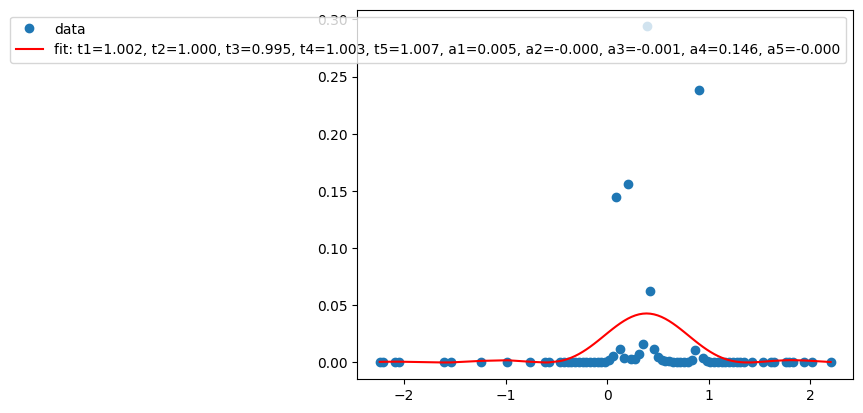

In [ ]:
# ORIGINAL DATA
xdata = np.array(energy_vec)
ydata = np.array(energy_prob)


# CURVE FIT
parameters, pcov = curve_fit(QPEProbability, xdata, ydata)

print(parameters)

plt.plot(xdata, ydata, 'o', label='data')


x_n = np.sort(xdata)
#print(x_n)

plt.plot(x_n, QPEProbability(x_n, *parameters), 'r-', label='fit: t1=%5.3f, t2=%5.3f, t3=%5.3f, t4=%5.3f, t5=%5.3f, a1=%5.3f, a2=%5.3f, a3=%5.3f, a4=%5.3f, a5=%5.3f' % tuple(parameters))
plt.legend()